# Introduction of Dark Matter: Exercise

In [1]:
%matplotlib widget

In [2]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

## 1 Dark Matter (DM) density profile

### 1.1

In [3]:
r_s = 24.42 # kpc
rho_s = 0.184 # GeV cm^{-3}
r_sun = 8.4 # kpc

In [4]:
def rho_NFW(r):
    """
    Parameters
    ----------
    r : float
        The radius from the GC in kpc.
    
    Returns
    -------
    rho_NFW : float
        The DM density in unit GeV cm^{-3}
    """
    x = r / r_s
    return rho_s / (x * np.power(1 + x, 2))

In [5]:
c = 299792458*u.m/u.s
G = 6.6743e-11*u.m**3/(u.kg*u.s**2) # m^3 kg^{-1} s^{-2}
M_BH = 4.154e6*u.M_sun 
R_sch = 2*G*M_BH/c**2
R_sch_kpc = R_sch.to(u.kpc).value
R_vir = 200*u.kpc
R_vir_kpc = R_vir.to(u.kpc).value
r_min = 2*R_sch
r_min_kpc = r_min.to(u.kpc).value

In [6]:
print(f'R_sch = {R_sch_kpc} kpc')

R_sch = 3.9757234811911793e-10 kpc


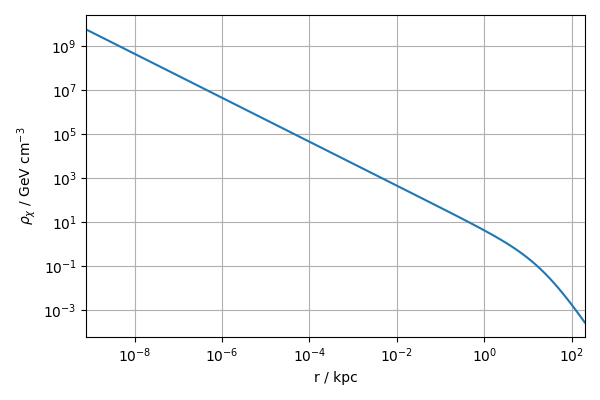

In [7]:
# Plot the NFW DM profile.
log10_r_min_kpc = np.log10(r_min_kpc)
log10_R_vir_kpc = np.log10(R_vir_kpc)
r = np.logspace(log10_r_min_kpc, log10_R_vir_kpc, int((log10_R_vir_kpc - log10_r_min_kpc)/0.1))

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.plot(r, rho_NFW(r), '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'r / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_xlim(r_min_kpc, R_vir_kpc)
ax.grid(which='both')
fig.tight_layout()
fig.savefig('/home/mwolf/rho_of_r.png')
plt.show()

### 1.2

Solve on paper.

In [8]:
def r_of_l_psi(l, psi):
    """Calculates the distance r from the GC given the l-o-s length l and angle
    psi.

    Parameters
    ----------
    l : array of float
        The l-o-s length l in kpc.
    psi : float
        The l-o-s angle psi in radian.

    Returns
    -------
    r : array of float
        The distance r from the GC. 
    """
    return np.sqrt(l**2 - 2*l*r_sun*np.cos(psi) + r_sun**2)

In [9]:
psi = np.deg2rad(0)
l = np.logspace(np.log10(0.1), np.log10(200), int((np.log10(200)-np.log10(0.1))/0.1))
r = r_of_l_psi(l=l, psi=psi)

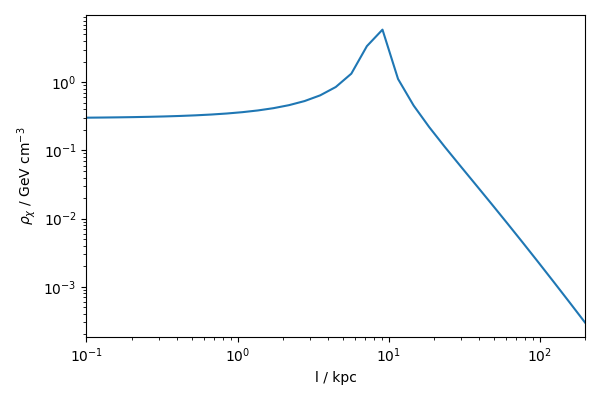

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.plot(l, rho_NFW(r), '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'l / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_xlim(np.min(l), np.max(l))
fig.tight_layout()
plt.show()

## 2 J-Factor and flux 

### 2.1

Solve on paper.

### 2.2

In [11]:
from scipy import integrate

In [12]:
def rho_chi(r):
    """Calculates the DM density rho_chi given in eq (1).
    
    Parameters:
    -----------
    r : float | array of float
        The distance from the GC in kpc.
    
    Returns
    -------
    rho_chi : array of float
        The DM density in GeV cm^{-3}.
    """
    r = np.atleast_1d(r)
    
    m = (r > 2*R_sch.to(u.kpc).value) & (r <= R_vir.to(u.kpc).value)
    
    rho_chi = np.zeros_like(r)
    rho_chi[m] = rho_NFW(r=r[m])
    
    return rho_chi

In [13]:
def rho_chi_of_l_psi(l, psi):
    r = r_of_l_psi(l=l, psi=psi)
    return rho_chi(r=r)

def l_integrand(l, psi):
    rho_sun = rho_chi(r=r_sun)[0]
    return 1 / r_sun * np.power(rho_chi_of_l_psi(l=l, psi=psi) / rho_sun, 2)

def l_integral(psi, l_min, l_max):
    res = integrate.quad(l_integrand, l_min, l_max, args=(psi,))
    return res[0]

def psi_integrand(psi, l_min, l_max):
    return np.sin(psi) * l_integral(psi=psi, l_min=l_min, l_max=l_max)

def psi_integral(l_min, l_max):
    res = integrate.quad(psi_integrand, 0, np.pi, args=(l_min, l_max))
    return res[0]

def J(l_min, l_max):
    return 2*np.pi * psi_integral(l_min=l_min, l_max=l_max)

In [14]:
l_min = 0
l_max = R_vir_kpc + r_sun
print(f'l_min = {l_min} kpc')
print(f'l_max = {l_max} kpc')
j_factor = J(l_min=l_min, l_max=l_max)
print(f'J factor = {j_factor}')

l_min = 0 kpc
l_max = 208.4 kpc
J factor = 34.67784905386016


### 2.3

Integration over all energies of $\frac{dN_{\gamma}}{dE} \equiv 2\delta(E - m_\chi)$ gives $N_{\gamma}=2$.

In [15]:
rho_sun = rho_chi(r=r_sun)[0] # GeV cm^-3
N_gamma = 2
Phi_gamma = (r_sun*u.kpc).to(u.cm) / (4*np.pi*2*2) * (3e-26*u.cm**3/u.s) * (rho_sun*u.GeV*u.cm**(-3)/(300*u.GeV))**2 * N_gamma * j_factor
print(f'rho_sun = {rho_sun} GeV cm^-3')
print(f'N_gamma = {N_gamma}')
print(f'Phi_gamma = {Phi_gamma}')

rho_sun = 0.296140879834115 GeV cm^-3
N_gamma = 2
Phi_gamma = 1.045484487786486e-09 1 / (cm2 s)


## 3 Spike structure

In [16]:
R_sp_kpc = 1/1000 # kpc
gamma_sp = 7/3

In [17]:
def rho_sp(r):
    """Calculates the spike DM density profile in unit GeV cm^{-3}.

    Parameters
    ----------
    r : array of float
        The distance from the GC in kpc.
    
    Returns
    -------
    rho_sp : array of float
        The spike DM density in GeV cm^{-3}. 
    """
    r = np.atleast_1d(r)

    m = (2*R_sch_kpc < r) & (r <= R_sp_kpc)

    v = rho_NFW(r=R_sp_kpc) * np.power(r/R_sp_kpc, -gamma_sp)
    rho = np.where(m, v, 0)

    return rho

### 3.2

Solving the differential equation by separating the variables.

$\int_{n_{\chi}(r,t_f)}^{n_{\chi}(r,t)} \frac{1}{n_{\chi}'^2}dn_{\chi}' = -\int_{t_f}^{t} \left<\sigma v\right> dt'$

### 3.3

In [18]:
rho_pl = (300*u.GeV / (3e-26*u.cm**3/u.s) / (10*u.Gyr).to(u.s)).value # GeV cm^{-3}
print(f'rho_pl = {rho_pl:g} ''GeV cm^{-3}')

rho_pl = 3.16881e+10 GeV cm^{-3}


In [19]:
R_pl_kpc = R_sp_kpc * np.power(rho_pl/rho_NFW(R_sp_kpc), -1/gamma_sp)
print(f'R_pl = {R_pl_kpc} kpc')

R_pl = 1.1614087459447114e-06 kpc


In [20]:
def rho_chi_sp_pl(r):
    """Calculates the DM density as function of the distance from the GC
    by taking into account the regions of the BH, the plateau, the spike,
    and the NFW.

    Parameters
    ----------
    r : float | array of float
        The distance from the GC.

    Returns
    -------
    rho_chi : array of float
        The DM density in GeV cm^{-3}.
    """
    r = np.atleast_1d(r)

    R_sch_kpc = R_sch.to(u.kpc).value

    # Create masks for all the regions.
    m_pl = (2*R_sch_kpc < r) & (r <= R_pl_kpc)
    m_sp = (R_pl_kpc < r) & (r <= R_sp_kpc)
    m_NFW = (R_sp_kpc < r) & (r <= R_vir_kpc)

    rho_chi = np.where(m_pl, rho_pl, 0)
    rho_chi = np.where(m_sp, rho_sp(r=r), rho_chi)
    rho_chi = np.where(m_NFW, rho_NFW(r=r), rho_chi)

    return rho_chi

In [21]:
r_min_kpc = 1e-10
log10_r_min_kpc = np.log10(1e-10)
r = np.logspace(log10_r_min_kpc, log10_R_vir_kpc, int((log10_R_vir_kpc - log10_r_min_kpc)/0.1))

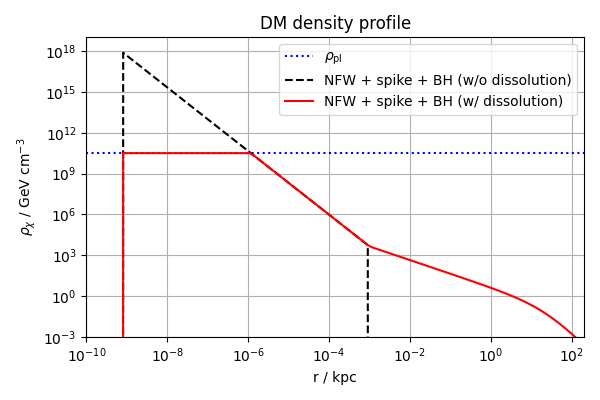

In [22]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.hlines(
    rho_pl, np.min(r), np.max(r),
    color='blue', 
    linestyles='dotted',
    label=r'$\rho_{\mathrm{pl}}$')
ax.plot(
    r, rho_sp(r=r), '--', 
    color='black',
    label='NFW + spike + BH (w/o dissolution)')
ax.plot(
    r, rho_chi_sp_pl(r=r), '-',
    color='red', 
    label='NFW + spike + BH (w/ dissolution)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'r / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_title('DM density profile')
ax.set_xlim(r_min_kpc, R_vir_kpc)
ax.set_ylim(1e-3, 1e19)
ax.grid(which='both')
ax.legend()
fig.tight_layout()
fig.savefig('/home/mwolf/rho_of_r_BH_spike_NFW.png')
plt.show()